In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("D:\corona\DATA\RSCCASN.csv")
data.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
DATE       334 non-null object
RSCCASN    334 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [4]:
# parse_dates = True : convert object date into Date format
df = pd.read_csv("D:\corona\DATA\RSCCASN.csv",parse_dates=True,index_col='DATE')
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [5]:
df.columns = ['Sales']
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


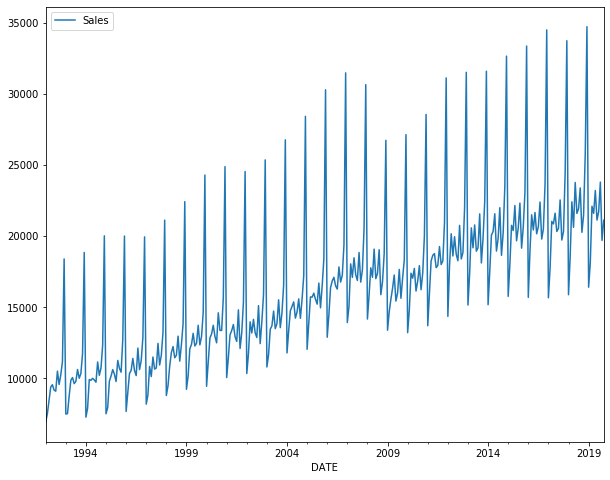

In [6]:
df.plot(figsize=(10,8))

## Train, Test Split

##### Q.) Where do we do your train test split?
##### >>> We should be doing a split at least a year's worth of information because there's clearly a yearly cycle. We should try to forcast at least one of these seasonality.
##### >>> On this data set we will be using 18 months

In [7]:
len(df)

334

###### 12 rows = 1 year & 18 rows = 1.5 years

In [8]:
len(df) - 18

316

In [9]:
test_size = 18
test_index = len(df) - test_size

In [10]:
train = df.iloc[:test_index]   # from starting till my test_index
test = df.iloc[test_index:]    # from test_index till the last

###### scale our data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
# Creating scaler version of training data 

scaled_train = scaler.transform(train)
scaled_test  = scaler.transform(test)

##### Creating TimeseriesGenerator 

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

###### Defining our batches 

###### Now something to keep in mind here is that i will add early_stopping & a validation generator because of that i need to make sure that the actual length of my batch is less than the length of my test.

In [14]:
length = 12   # bcz it's a whole year   (length of a batch)
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=length,
                                batch_size=1) # if batch_size=2 | Then we will have 2 set of array for X & 2 set of array for y 

In [15]:
generator[0]  # 1st batch 

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]), array([[0.02047633]]))

In [16]:
X,y = generator[0]

In [17]:
# Given the value of 12 months 
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [18]:
y            # predicting the value of 13th month

array([[0.02047633]])

In [19]:
# scaled_train

###### Scale our data                    ✔
###### TimeseriesGenerator         ✔

## Creating a Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Now we are only using 1 feature on Timeseries essentially the previous scales data
n_features = 1  # number of features

model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))  # input_shape = length of the batch / number of features

model.add(Dense(1)) # add Dense layer to have 1 final predictive output

model.compile(optimizer='adam',loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


###### creating early stopping

In [22]:
# RNNS take really long time to train & it takes many epochs to train. So we create here an early stopping mechanism so i 
#  can just set an arbitrarity high number of epoches & let tensorfow do the work of figuring out when to stop training.

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', patience = 2) 

# patience : Number of epochs with no improvement after which training will be stopped.

##### creating a validation generator

In [23]:
validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test,
                                           length=length,
                                           batch_size=1)

In [24]:
model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 18s 60ms/step - loss: 0.0258 - val_loss: 0.0057
Epoch 2/20
304/304 [==============================] - 16s 52ms/step - loss: 0.0179 - val_loss: 0.0047
Epoch 3/20
304/304 [==============================] - 16s 54ms/step - loss: 0.0128 - val_loss: 0.0012
Epoch 4/20
304/304 [==============================] - 16s 54ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 5/20
304/304 [==============================] - 18s 58ms/step - loss: 0.0037 - val_loss: 0.0023


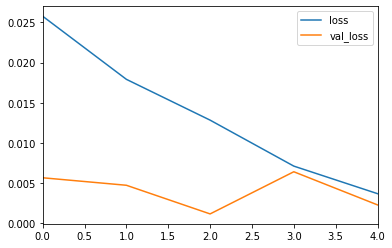

In [25]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [26]:
# Let's see our test data & see how did we performed

test_predictions = []

# What my 1st training batch will going to look like?
first_eval_batch = scaled_train[-length:] # it is the very last batch points for my scaled_training set

# we are going to grab last 12 months of my training set to predict 1 month into the future i.e 1st point in test_set i.e my
# first_eval_batch


# then i should reshape it in a correct format 

# Number of items passing per batch = 1
# length     =  12 months
# n_features =  1 'y' feature
# then i'll get my curr_batch
curr_batch = first_eval_batch.reshape((1,length,n_features))


# For the entire len of my test set 
for i in range(len(test)):
    
    # In this case i get prediction 1 time stamp ahead([0] is for grabbing just the number)
    curr_pred = model.predict(curr_batch)[0]
    
    # append curr_pred to test_predictions
    test_predictions.append(curr_pred)
    
    # 1: => drops very 1st val in that curr_batch & then I append our curr_pred values 
    # Essentially moving curr_batch 1 month into the future
    curr_batch=np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

In [27]:
# we have our test_prediction values but they are scaled so we need to inverse that transformation

true_predictions = scaler.inverse_transform(test_predictions)

In [28]:
test['Predictions'] = true_predictions

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22079.814094
2018-06-01,21589,21151.332042
2018-07-01,21919,21437.045853
2018-08-01,23381,23087.747011
2018-09-01,20260,20960.647666
2018-10-01,21473,21620.165043
2018-11-01,25831,25639.260161
2018-12-01,34706,35868.477859
2019-01-01,16410,17277.024528


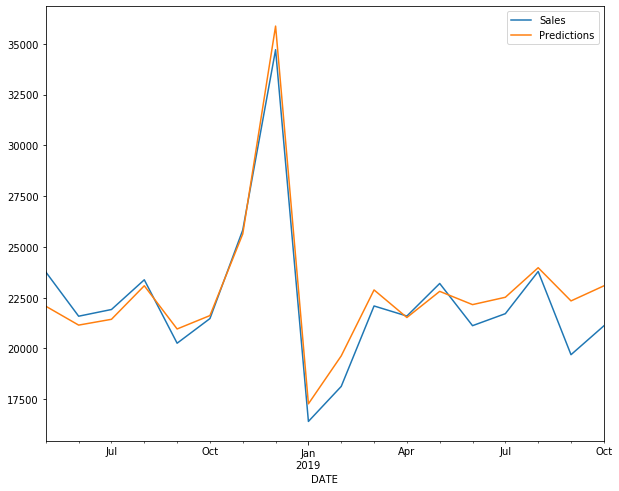

In [30]:
test.plot(figsize=(10,8))

## Try to forcast into unknown future

#### What we will do is retrain on all data & then again we will do our scaling, do our retraining & then we will do true forcast

###### If the above graph is good enough to forcast values then this we will do into the future

## Scaling our Data

In [31]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)

In [32]:
length = 12

generator1 = TimeseriesGenerator(scaled_full_data,
                                 scaled_full_data,
                                 length=length,
                                 batch_size=1)

In [33]:
model1 = Sequential()
model1.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model1.add(Dense(1))
model1.compile(optimizer='adam',loss='mse')
model1.fit_generator(generator1,epochs=8)

Epoch 1/8
322/322 [==============================] - 18s 55ms/step - loss: 0.0232
Epoch 2/8
322/322 [==============================] - 17s 54ms/step - loss: 0.0146
Epoch 3/8
322/322 [==============================] - 19s 58ms/step - loss: 0.0060
Epoch 4/8
322/322 [==============================] - 18s 57ms/step - loss: 0.0038
Epoch 5/8
322/322 [==============================] - 18s 55ms/step - loss: 0.0019
Epoch 6/8
322/322 [==============================] - 19s 58ms/step - loss: 0.0020
Epoch 7/8
322/322 [==============================] - 18s 55ms/step - loss: 0.0015
Epoch 8/8
322/322 [==============================] - 19s 58ms/step - loss: 0.0013


In [34]:
forecast = []

periods = 12      # more the number is ....more the noice will be 

first_eval_batch = scaled_full_data[-length:]

curr_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
    
    curr_pred = model1.predict(curr_batch)[0]

    forecast.append(curr_pred)
    
    curr_batch=np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

In [35]:
forecast = scaler.inverse_transform(forecast)

In [36]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [37]:
forecast

array([[25791.51937103],
       [35886.82277775],
       [16054.66424036],
       [17917.6929698 ],
       [21588.80432844],
       [21248.88484669],
       [22866.83636951],
       [20918.71736193],
       [21577.04118729],
       [23559.18218708],
       [19782.62120438],
       [21251.8629818 ]])

In [38]:
# add the above value with time stamp

forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq="MS") # MS : Month start freq (Offset Aliases)

In [39]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [40]:
# Combine Forecast val with forecast_index

forecast_df = pd.DataFrame(data = forecast,
                           index = forecast_index,
                           columns=['Forecaste'] )

In [41]:
forecast_df

,Forecaste
2019-11-01,25791.519371
2019-12-01,35886.822778
2020-01-01,16054.664240
2020-02-01,17917.692970
2020-03-01,21588.804328
2020-04-01,21248.884847
2020-05-01,22866.836370
2020-06-01,20918.717362
2020-07-01,21577.041187
2020-08-01,23559.182187


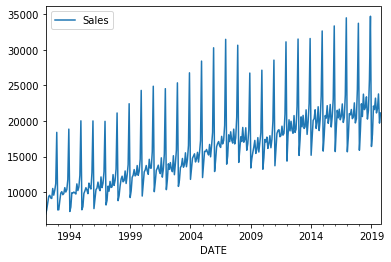

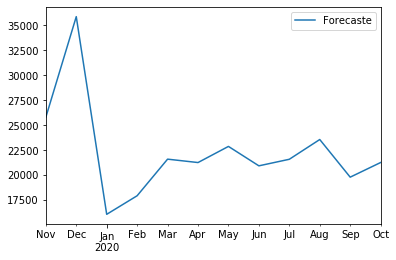

In [42]:
df.plot()
forecast_df.plot()

<Figure size 720x576 with 0 Axes>

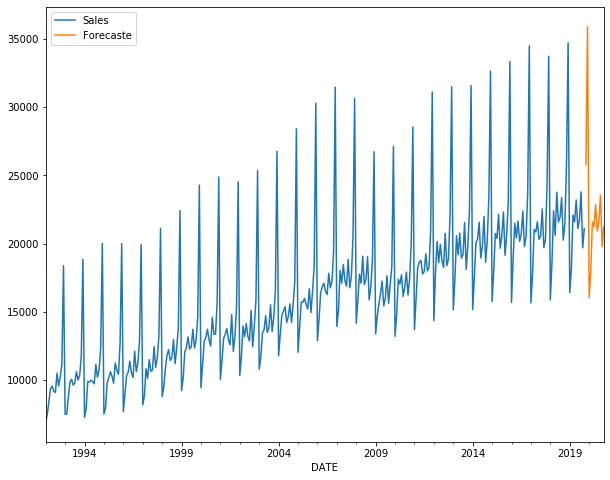

In [45]:
ax = df.plot()
forecast_df.plot(ax = ax,figsize=(10,8))

(576, 611)

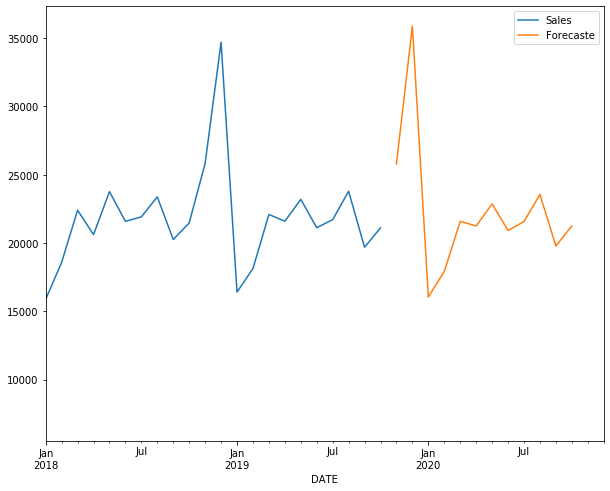

In [46]:
# Zoom in values

ax = df.plot()
forecast_df.plot(ax = ax,figsize=(10,8))
plt.xlim('2018-01-01','2020-12-01')